# Processing RBPs and PWMs from Attract, RBPDB and ENCODE databases

### Import

In [1]:
import numpy as np
import pandas as pd
import re
import h5py
import matplotlib.pyplot as plt
import seqlogo

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Find SMEAGOL
import sys
sys.path.append('../../SMEAGOL')

from smeagol.matrices import *
from smeagol.visualize import *
from smeagol.io import *

### Read RBPs from Attract

In [2]:
rbps = pd.read_csv('../DATA/PWMS/ATtRACT/ATtRACT_db.txt', sep="\t")
rbps.head()

,Gene_name,Gene_id,Mutated,Organism,Motif,Len,Experiment_description,Database,Pubmed,Experiment_description.1,Family,Matrix_id,Score
0,3IVK,3IVK,no,Mus_musculus,GAAACA,6,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,519,1.000000**
1,3IVK,3IVK,no,Mus_musculus,UGGG,4,X-RAY DIFFRACTION,PDB,19965478,X-RAY DIFFRACTION,NaN,574,1.000000**
2,4KZD,4KZD,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,464,1.000000**
3,4KZE,4KZE,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,437,1.000000**
4,4Q9Q,4Q9Q,no,Mus_musculus,GAAAC,5,X-RAY DIFFRACTION,PDB,24952597,X-RAY DIFFRACTION,NaN,423,1.000000**


### Filter human RBPs only

In [3]:
rbps = rbps[rbps.Organism=="Homo_sapiens"]

### Filter multiple-sequence motifs

In [4]:
rbps = rbps[rbps.Score!="1.000000**"]

### Filter non-mutated proteins

In [5]:
rbps = rbps[rbps.Mutated == 'no']

### Remove matrix that is listed for two proteins

In [6]:
rbps = rbps[rbps.Matrix_id!='s99'].copy()

### Count experiment types

In [7]:
is_selex = np.array([re.search('SELEX', x)!=None for x in rbps.Experiment_description])
rbps.loc[is_selex, 'Experiment_description'] = 'SELEX'
rbps.Experiment_description.value_counts()

SELEX                                      1280
RNAcompete                                  678
RIP-chip                                     68
single RNA affinity purification             64
genome-wide in vivo immunoprecipitation      58
NMR                                          54
protein affinity purification                45
RNAcompete using recombinant protein         25
PAR-clip                                      4
UV cross-linking                              2
Name: Experiment_description, dtype: int64

### Filter columns

In [8]:
rbps = rbps.loc[:,['Gene_name', 'Gene_id', 'Matrix_id', 'Experiment_description']].drop_duplicates().reset_index(drop=True)
print(len(rbps))
rbps.head()

229


,Gene_name,Gene_id,Matrix_id,Experiment_description
0,A1CF,ENSG00000148584,M001_0.6,RNAcompete
1,ACO1,ENSG00000122729,M256_0.6,SELEX
2,ANKHD1,ENSG00000131503,M002_0.6,RNAcompete
3,CELF1,ENSG00000149187,s86,SELEX
4,CELF2,ENSG00000048740,s4,SELEX


In [9]:
rbps['source'] = 'Attract'

### Read Attract PPMs

In [10]:
ppms = read_pms_from_file('../DATA/PWMS/ATtRACT/pwm.txt', check_lens=True)
ppms.head()

/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/smeagol/matrices.py:29: UserWarning: Rows do not all sum to 1. Check the values.
  warnings.warn('Rows do not all sum to 1. Check the values.')


,Matrix_id,probs
0,904,"[[0.009615385, 0.009615385, 0.009615385, 0.971..."
1,s36,"[[0.8443251, 0.00076687115, 0.1541411, 0.00076..."
2,M269_0.6,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ..."
3,M120_0.6,"[[0.055227987, 0.055227987, 0.44783142, 0.4417..."
4,705,"[[0.009615385, 0.009615385, 0.97115386, 0.0096..."


In [11]:
[x.sum(axis=1) for x in ppms.probs][:5]

[array([1.        , 1.        , 1.        , 1.        , 0.99999994],
       dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([1.        , 1.        , 0.98999995, 1.        , 1.        ,
        1.        , 0.99      , 1.        , 1.        , 1.        ,
        1.        ], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([1.        , 0.99999994, 0.99999994, 0.99999994, 0.99999994,
        1.        , 1.        , 0.99999994, 1.        , 0.99999994,
        0.99999994], dtype=float32)]

### re-normalize PPMs

In [16]:
ppms.probs = [normalize_pm(x) for x in ppms.probs]

In [17]:
[x.sum(axis=1) for x in ppms.probs][:5]

[array([1., 1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)]

### Filter PPMs to selected RBPs

In [18]:
ppms = ppms.merge(rbps, on='Matrix_id').reset_index(drop=True)
print(len(ppms))

229


### Read RBPDB

In [19]:
prot=pd.read_csv("../DATA/PWMs/RBPDB/RBPDB_v1.3.1_human_2012-11-21_TDT/RBPDB_v1.3.1_proteins_human_2012-11-21.tdt", 
            header=None,  sep="\t", usecols=(0,1,4), names=("Prot_id", "Gene_id", "Gene_name"))
exp=pd.read_csv("../DATA/PWMs/RBPDB/RBPDB_v1.3.1_human_2012-11-21_TDT/RBPDB_v1.3.1_experiments_human_2012-11-21.tdt", 
            header=None,  sep="\t", usecols=(0,2), names=("Matrix_id", 'Experiment_description'))
prot_exp = pd.read_csv("../DATA/PWMs/RBPDB/RBPDB_v1.3.1_human_2012-11-21_TDT/RBPDB_v1.3.1_protExp_human_2012-11-21.tdt", 
            header=None,  sep="\t", usecols=(0,1), names=('Prot_id', 'Matrix_id'))

In [20]:
rbps2 = prot.merge(prot_exp, on='Prot_id').merge(exp, on='Matrix_id').reset_index(drop=True)

In [21]:
rbps2.Experiment_description.value_counts()

protein affinity purification              413
EMSA                                       410
UV cross-linking                           262
SELEX                                       83
genome-wide in vivo immunoprecipitation     59
NMR                                         57
homopolymer binding assay                   47
filter binding assay                        27
fluorescence methods                        24
single RNA affinity purification            11
biosensor analysis                          10
RNAcompete                                   8
yeast three-hybrid screen                    7
RNA footprinting                             4
yeast three-hybrid assay                     3
ELISA with biotinylated RNA                  1
in vitro RNA pulldown                        1
Name: Experiment_description, dtype: int64

In [22]:
rbps2.head()

,Prot_id,Gene_id,Gene_name,Matrix_id,Experiment_description
0,1226,ENSG00000003756,RBM5,108,EMSA
1,1226,ENSG00000003756,RBM5,110,homopolymer binding assay
2,1231,ENSG00000009307,CSDE1,257,EMSA
3,1231,ENSG00000009307,CSDE1,258,EMSA
4,1231,ENSG00000009307,CSDE1,260,SELEX


In [23]:
rbps2 = rbps2.loc[:, ['Matrix_id', 'Gene_id', 'Gene_name', 'Experiment_description']].drop_duplicates().reset_index(drop=True)
rbps2.Matrix_id = rbps2.Matrix_id.astype(str)
rbps2['source'] = 'RBPDB'
rbps2.head()

,Matrix_id,Gene_id,Gene_name,Experiment_description,source
0,108,ENSG00000003756,RBM5,EMSA,RBPDB
1,110,ENSG00000003756,RBM5,homopolymer binding assay,RBPDB
2,257,ENSG00000009307,CSDE1,EMSA,RBPDB
3,258,ENSG00000009307,CSDE1,EMSA,RBPDB
4,260,ENSG00000009307,CSDE1,SELEX,RBPDB


### Read RBPDB PFMs and convert to PPMs

In [24]:
ppms2 = read_pms_from_dir('../DATA/PWMs/RBPDB/PFMDir', matrix_type='PFM', transpose=True)
ppms2['probs'] = [pfm_to_ppm(x, pseudocount = .01) for x in ppms2.freqs]
print(len(ppms2))

53


/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/smeagol/matrices.py:51: UserWarning: Input array contains fractional values.
  warnings.warn('Input array contains fractional values.')


In [25]:
ppms2 = ppms2.merge(rbps2, on='Matrix_id')
print(len(ppms2))

53


In [26]:
ppms2.Experiment_description.value_counts()

SELEX         45
RNAcompete     8
Name: Experiment_description, dtype: int64

### Load ENCODE PMs

In [27]:
ppms3 = pd.read_hdf('../DATA/PWMs/encode_pwms.h5', key='data')
ppms3.rename(columns = {'RBP': 'Gene_name'}, inplace=True)
ppms3.drop(columns='logo', inplace=True)
ppms3['source'] = 'ENCODE'
ppms3['Experiment_description'] = 'RBNS'

In [28]:
ppms3.head(3)

,Gene_name,Matrix_id,probs,source,Experiment_description
0,A1CF,encode_A1CF_1,"[[0.19215530903328054, 0.1370839936608558, 0.1...",ENCODE,RBNS
1,BOLL,encode_BOLL_1,"[[0.176716799091941, 0.176716799091941, 0.1767...",ENCODE,RBNS
2,CELF1,encode_CELF1_1,"[[0.20051143200962698, 0.12048736462093865, 0....",ENCODE,RBNS


### Concatenate all PMs

In [29]:
ppms = pd.concat([ppms, ppms2, ppms3]).reset_index(drop=True)

In [30]:
ppms.head(3)

,Matrix_id,probs,Gene_name,Gene_id,Experiment_description,source,freqs
0,s36,"[[0.8443251, 0.00076687115, 0.1541411, 0.00076...",HNRNPDL,ENSG00000152795,SELEX,Attract,NaN
1,M269_0.6,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ...",ZFP36,ENSG00000128016,SELEX,Attract,NaN
2,M157_0.6,"[[0.08396381, 0.08396381, 0.08396381, 0.748108...",CELF5,ENSG00000161082,RNAcompete,Attract,NaN


In [31]:
len(ppms)

411

### Check for different protein names

In [32]:
attract_proteins = pd.unique(ppms.Gene_name[ppms.source=="Attract"])
rbpdb_proteins = pd.unique(ppms.Gene_name[ppms.source=="RBPDB"])
encode_proteins = pd.unique(ppms.Gene_name[ppms.source=="ENCODE"])
print(len(attract_proteins), len(rbpdb_proteins), len(encode_proteins))

106 29 78


In [33]:
set(rbpdb_proteins).difference(set(attract_proteins))

{'A2BP1', 'NCL', 'RBMX', 'SFRS1', 'SFRS13A', 'SFRS2', 'SFRS7', 'SFRS9'}

In [34]:
set(encode_proteins).difference(set(attract_proteins))

{'BOLL',
 'CPEB1',
 'DAZ3',
 'EIF4G2',
 'ELAVL4',
 'ESRP1',
 'EWSR1',
 'FUBP1',
 'FUBP3',
 'HNRNPA0',
 'HNRNPD',
 'ILF2',
 'NUPL2',
 'PABPN1L',
 'PCBP4',
 'PRR3',
 'PTBP3',
 'PUF60',
 'RALYL',
 'RBFOX2',
 'RBFOX3',
 'RBM15B',
 'RBM22',
 'RBM23',
 'RBM25',
 'RBM45',
 'RBM47',
 'RBM4B',
 'RBMS2',
 'RC3H1',
 'SF1',
 'SRSF11',
 'SRSF4',
 'SRSF8',
 'TAF15',
 'TRA2A',
 'TRNAU1AP',
 'UNK',
 'ZNF326'}

### Harmonize protein names

In [35]:
ppms.loc[ppms.Gene_name=='A2BP1', 'Gene_name'] = 'RBFOX1'
ppms.loc[ppms.Gene_name=='SFRS1', 'Gene_name'] = 'SRSF1'
ppms.loc[ppms.Gene_name=='SFRS13A', 'Gene_name'] = 'SRSF10'
ppms.loc[ppms.Gene_name=='SFRS2', 'Gene_name'] = 'SRSF2'
ppms.loc[ppms.Gene_name=='SFRS7', 'Gene_name'] = 'SRSF7'
ppms.loc[ppms.Gene_name=='SFRS9', 'Gene_name'] = 'SRSF9'

### Drop duplicate motifs

In [36]:
duplicate_motifs_rbpdb = ['1213', '350', '782', '783', '784', '637', '23', '359', '669', '488', '680', '682',
                          '24', '950', '1171', '37', '1172', '1052', '661', '663', '946', '1173', '242', '952',
                         '1169', '244', '791', '790', '954', '797', '1177', '969', '951']

In [37]:
ppms = ppms[~ppms.Matrix_id.isin(duplicate_motifs_rbpdb)]

In [38]:
ppms.source.value_counts()

Attract    229
ENCODE     129
RBPDB       20
Name: source, dtype: int64

### Trim PPMs by position-wise IC

In [39]:
ppms['orig_len'] = [p.shape[0] for p in ppms.probs]

In [40]:
ppms['trimmed_probs'] = ppms.probs.apply(trim_ppm, args=(0.1,))

In [41]:
ppms['trimmed_len'] = [p.shape[0] for p in ppms.trimmed_probs]

In [42]:
print(str(len(ppms[ppms.orig_len!=ppms.trimmed_len])) + " PPMs were trimmed!")
#ppms[ppms.orig_len!=ppms.trimmed_len]

44 PPMs were trimmed!


In [43]:
ppms.drop(columns=['probs', 'orig_len'], inplace=True)
ppms.rename(columns={'trimmed_probs':'probs', 'trimmed_len':'len'}, inplace=True)

### Filter by length

In [44]:
ppms = ppms[ppms.len >= 4].copy()
print(len(ppms))

376


In [45]:
ppms = ppms[ppms.len <= 12].copy()
print(len(ppms))

373


### Calculate entropy

In [46]:
ppms['entropy'] = ppms.probs.apply(entropy)
ppms.head()

,Matrix_id,Gene_name,Gene_id,Experiment_description,source,freqs,probs,len,entropy
0,s36,HNRNPDL,ENSG00000152795,SELEX,Attract,NaN,"[[0.8443251, 0.00076687115, 0.1541411, 0.00076...",7,8.475865
1,M269_0.6,ZFP36,ENSG00000128016,SELEX,Attract,NaN,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ...",11,6.236948
2,M157_0.6,CELF5,ENSG00000161082,RNAcompete,Attract,NaN,"[[0.08396381, 0.08396381, 0.08396381, 0.748108...",7,5.910135
3,M042_0.6,PABPC4,ENSG00000090621,RNAcompete,Attract,NaN,"[[0.77843714, 0.10307988, 0.11052549, 0.007957...",7,5.255954
4,M062_0.6,SART3,ENSG00000075856,RNAcompete,Attract,NaN,"[[0.7570201, 0.080993265, 0.080993265, 0.08099...",7,5.665008


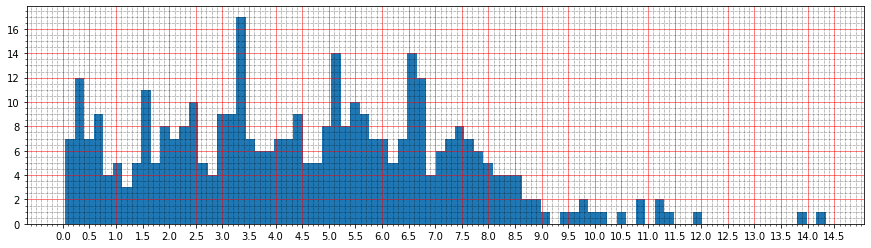

In [47]:
fig, ax = plt.subplots(figsize=(15,4))
plt.hist(ppms.entropy, 80)
ax.grid()

plt.xticks(np.arange(0, np.ceil(max(ppms.entropy)), 0.5))
ax.minorticks_on()

ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

In [48]:
try_max_entropy = 10
ppms[ppms.entropy > try_max_entropy].sort_values('entropy').head(5)

,Matrix_id,Gene_name,Gene_id,Experiment_description,source,freqs,probs,len,entropy
10,s49,SRSF1,ENSG00000136450,SELEX,Attract,NaN,"[[0.00034435265, 0.998967, 0.00034435265, 0.00...",7,10.017073
107,s18,FMR1,ENSG00000102081,SELEX,Attract,NaN,"[[0.0007122507, 0.0007122507, 0.99786323, 0.00...",12,10.107212
292,encode_EWSR1_1,EWSR1,NaN,RBNS,ENCODE,NaN,"[[0.07345360824742267, 0.07345360824742267, 0....",8,10.476617
141,s25,SFPQ,ENSG00000116560,SELEX,Attract,NaN,"[[0.0012437811, 0.0012437811, 0.37437811, 0.62...",9,10.897651
63,s59,SRSF2,ENSG00000161547,SELEX,Attract,NaN,"[[0.08351831, 0.055771366, 0.8326859, 0.028024...",8,10.916107


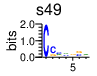

In [49]:
plot_ppm(ppms, 's49', 5)

### Filter by entropy

In [50]:
min_entropy = 0
max_entropy = 10
ppms = ppms[(ppms.entropy > min_entropy) & (ppms.entropy < max_entropy)]
len(ppms)

362

## Convert PPM to PWM

In [51]:
pwms = ppms.reset_index(drop=True)
pwms['weights'] = [ppm_to_pwm(p) for p in pwms.probs]
pwms.head()

,Matrix_id,Gene_name,Gene_id,Experiment_description,source,freqs,probs,len,entropy,weights
0,s36,HNRNPDL,ENSG00000152795,SELEX,Attract,NaN,"[[0.8443251, 0.00076687115, 0.1541411, 0.00076...",7,8.475865,"[[1.7558706, -8.348728, -0.69767654, -8.348728..."
1,M269_0.6,ZFP36,ENSG00000128016,SELEX,Attract,NaN,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ...",11,6.236948,"[[1.9560567, -4.643856, -4.643856, -4.643856],..."
2,M157_0.6,CELF5,ENSG00000161082,RNAcompete,Attract,NaN,"[[0.08396381, 0.08396381, 0.08396381, 0.748108...",7,5.910135,"[[-1.5740886, -1.5740886, -1.5740886, 1.581319..."
3,M042_0.6,PABPC4,ENSG00000090621,RNAcompete,Attract,NaN,"[[0.77843714, 0.10307988, 0.11052549, 0.007957...",7,5.255954,"[[1.6386524, -1.2781653, -1.177549, -4.9734616..."
4,M062_0.6,SART3,ENSG00000075856,RNAcompete,Attract,NaN,"[[0.7570201, 0.080993265, 0.080993265, 0.08099...",7,5.665008,"[[1.5984036, -1.6260543, -1.6260543, -1.626054..."


## Save

In [52]:
pwms.to_hdf('../DATA/PWMs/attract_rbpdb_encode_filtered_human_pwms.h5', key='data')

/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/pandas/core/generic.py:2621: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['Matrix_id', 'Gene_name', 'Gene_id', 'Experiment_description', 'source',
       'freqs', 'probs', 'weights'],
      dtype='object')]

  encoding=encoding,


In [54]:
pwms.loc[:,['Matrix_id','Gene_name','Gene_id','Experiment_description','source', 'len']].to_csv('../DATA/PWMs/attract_rbpdb_encode_filtered_human_pwms.csv')